# Creating a Pipeline of the Best Models

Using Optuna in this separate notebook and resplitting the data seems to perform better than in the notebooks that were used for testing/experimenting. Although, they don't seem to perform as well as the manual hyperparameter tuning with functions. We believe this is due to Optuna possibly overfitting or underfitting our data due to the small sample size. Also, in the future with a smaller dataset we will experiment with k-fold cross validation rather than having a separate validation set so that we can maximize our testing and training data.
<br>
Random_state was missing, these results may differ from the presentation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import optuna
import shap

In [2]:
X_resampled = pd.read_csv('X_full.csv')
y_resampled = pd.read_csv('y_full.csv')

In [3]:
# create a function to split the dataset into train, validation and test sets
def data_split(X, y, train_size, val_size, test_size, shuffle = True):
    if shuffle:
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X.iloc[idx].reset_index(drop=True)
        y = y.iloc[idx].reset_index(drop=True)

    # check the portion sizes
    if (train_size + val_size + test_size) != 1:
        portion_size = train_size + val_size + test_size * 100
        # normalize portion sizes
        train_size = train_size/ portion_size
        val_size = val_size/ portion_size
        test_size = test_size/ portion_size

    # split data
    split_data = []
    start = 0
    for size in [train_size, val_size, test_size]:
        end = start + int(size * len(X))
        split_data.append((X.iloc[start:end], y.iloc[start:end]))
        start = end
    return split_data

In [4]:
# Use the defined function to split the data into test, train, and validation
train, val, test = data_split(X_resampled, y_resampled, 0.6, 0.2, 0.2)

# Further split the data into X and y train, test, and validation
train_X, train_y = train
val_X, val_y = val
test_X, test_y = test
train_y = train_y.to_numpy().ravel()
val_y = val_y.to_numpy().ravel()
test_y = test_y.to_numpy().ravel()

# show shape of all the data
print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)
print("val_X shape:", val_X.shape)
print("val_y shape:", val_y.shape)
print("test_X shape:", test_X.shape)
print("test_y shape:", test_y.shape)

train_X shape: (176, 22)
train_y shape: (176,)
val_X shape: (58, 22)
val_y shape: (58,)
test_X shape: (58, 22)
test_y shape: (58,)


In [5]:
train_X

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,121.345,139.644,98.250,0.00684,0.000060,0.00388,0.00332,0.01164,0.02534,0.241,...,0.02056,0.04019,0.04179,21.520,0.566867,0.670475,-4.865194,0.246404,2.013530,0.168581
1,228.832,234.619,223.634,0.00296,0.000010,0.00175,0.00155,0.00526,0.01644,0.145,...,0.01179,0.02647,0.00351,25.964,0.256570,0.683296,-7.245620,0.018689,2.498224,0.093534
2,122.964,130.049,114.676,0.00428,0.000030,0.00124,0.00155,0.00373,0.01681,0.154,...,0.01400,0.02789,0.00462,24.971,0.538688,0.754073,-6.482096,0.264967,2.054419,0.128872
3,116.848,217.552,99.503,0.00531,0.000050,0.00260,0.00346,0.00780,0.01795,0.163,...,0.01756,0.02429,0.01179,22.085,0.663842,0.656516,-5.198864,0.206768,2.120412,0.252404
4,117.004,144.466,99.923,0.00353,0.000030,0.00176,0.00218,0.00528,0.01657,0.145,...,0.01318,0.02643,0.00590,25.445,0.387482,0.756482,-6.012559,0.229298,1.872946,0.163118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,209.144,237.494,109.379,0.00282,0.000010,0.00147,0.00152,0.00442,0.01861,0.170,...,0.01382,0.02925,0.00871,25.554,0.341788,0.678874,-7.040508,0.066994,2.460791,0.101516
172,110.793,128.101,107.316,0.00494,0.000040,0.00260,0.00283,0.00780,0.02442,0.216,...,0.01831,0.04295,0.00479,25.438,0.437031,0.815908,-5.313360,0.201861,2.225815,0.244512
173,203.184,211.526,196.160,0.00178,0.000009,0.00094,0.00106,0.00283,0.00958,0.085,...,0.00726,0.01403,0.00065,33.047,0.340068,0.741899,-7.964984,0.163519,1.423287,0.044539
174,243.439,250.912,232.435,0.00210,0.000009,0.00109,0.00137,0.00327,0.01419,0.126,...,0.01033,0.02330,0.00454,25.368,0.438296,0.635285,-7.057869,0.091608,2.330716,0.091470


## PowerTransformer - PCA - DecisionTree

In [6]:
def objective(trial):
    # PowerTransformer
    pt_method = trial.suggest_categorical('pt_method', ['yeo-johnson'])
    pt = PowerTransformer(method=pt_method)

    # PCA
    pca_n_components = trial.suggest_int('pca_n_components', 1, train_X.shape[1], log=False)
    pca = PCA(n_components=pca_n_components)

    # Decision Tree
    dt_max_depth = trial.suggest_int('dt_max_depth', 1, 23, log=False)
    dt_max_feats = trial.suggest_int('dt_max_feats', 1, 23, log=False)
    dt = DecisionTreeClassifier(max_depth=dt_max_depth)
#    params = {
#        'max_depth': trial.suggest_int('max_depth', 1, 32),
#        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
#        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
#        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
#        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 32),
#        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
#    }
#    dt = DecisionTreeClassifier(**params)


    # Create the pipeline
    pipeline = Pipeline([
        ('power_transformer', pt),
        ('pca', pca),
        ('classifier', dt)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(train_X, train_y)

    # Evaluate the pipeline on the validation set
    y_pred_val = pipeline.predict(val_X)
    accuracy_val = accuracy_score(val_y, y_pred_val)

    return 1.0 - accuracy_val

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

#dt_params = {
#    'max_depth': best_params['max_depth'],
#    'min_samples_split': best_params['min_samples_split'],
#    'min_samples_leaf': best_params['min_samples_leaf'],
#    'max_features': best_params['max_features'],
#    'max_leaf_nodes': best_params['max_leaf_nodes'],
#    'criterion': best_params['criterion']
#}

# Train the best pipeline on the entire training set
best_pipeline_pow = Pipeline([
    ('power_transformer', PowerTransformer(method=best_params['pt_method'])),
    ('pca', PCA(random_state=42,  n_components=best_params['pca_n_components'])),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=best_params['dt_max_depth'], max_features=best_params['dt_max_feats']))
#    ('classifier', DecisionTreeClassifier(**dt_params))
])
best_pipeline_pow.fit(train_X, train_y)

# Evaluate the best pipeline on the test set
y_pred_test = best_pipeline_pow.predict(test_X)
accuracy_test = accuracy_score(test_y, y_pred_test)
print(f"Pipeline Accuracy on Test Set: {accuracy_test}")

[I 2023-12-06 19:27:20,707] A new study created in memory with name: no-name-66c3168f-d368-4b80-b91c-a63e20f7ddea
[I 2023-12-06 19:27:20,775] Trial 0 finished with value: 0.10344827586206895 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 15, 'dt_max_depth': 5, 'dt_max_feats': 1}. Best is trial 0 with value: 0.10344827586206895.
[I 2023-12-06 19:27:20,844] Trial 1 finished with value: 0.15517241379310343 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 10, 'dt_max_depth': 3, 'dt_max_feats': 3}. Best is trial 0 with value: 0.10344827586206895.
[I 2023-12-06 19:27:20,924] Trial 2 finished with value: 0.27586206896551724 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 10, 'dt_max_depth': 1, 'dt_max_feats': 7}. Best is trial 0 with value: 0.10344827586206895.
[I 2023-12-06 19:27:20,989] Trial 3 finished with value: 0.10344827586206895 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 13, 'dt_max_depth': 8, 'dt_max_feats': 5}.

[I 2023-12-06 19:27:23,199] Trial 35 finished with value: 0.10344827586206895 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 11, 'dt_max_depth': 7, 'dt_max_feats': 11}. Best is trial 13 with value: 0.03448275862068961.
[I 2023-12-06 19:27:23,280] Trial 36 finished with value: 0.12068965517241381 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 6, 'dt_max_depth': 21, 'dt_max_feats': 18}. Best is trial 13 with value: 0.03448275862068961.
[I 2023-12-06 19:27:23,370] Trial 37 finished with value: 0.10344827586206895 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 20, 'dt_max_depth': 12, 'dt_max_feats': 13}. Best is trial 13 with value: 0.03448275862068961.
[I 2023-12-06 19:27:23,456] Trial 38 finished with value: 0.18965517241379315 and parameters: {'pt_method': 'yeo-johnson', 'pca_n_components': 2, 'dt_max_depth': 19, 'dt_max_feats': 16}. Best is trial 13 with value: 0.03448275862068961.
[I 2023-12-06 19:27:23,529] Trial 39 finished with 

Pipeline Accuracy on Test Set: 0.8793103448275862


In [7]:
# Function to get the most important features for each principal component
def get_most_important_features(pca, train_X):
    n_pcs = pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names = list(train_X.columns)
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    most_import = pd.DataFrame(dic.items())
    return most_import

# Get the most important features from PCA
most_important_features = get_most_important_features(best_pipeline_pow.named_steps['pca'], train_X)

# Display the most important features
display(most_important_features)

,0,1
0,PC0,MDVP:APQ
1,PC1,MDVP:Fhi(Hz)
2,PC2,DFA
3,PC3,RPDE
4,PC4,spread2


The above figure shows the features with the most expained variance on the PCA components. 

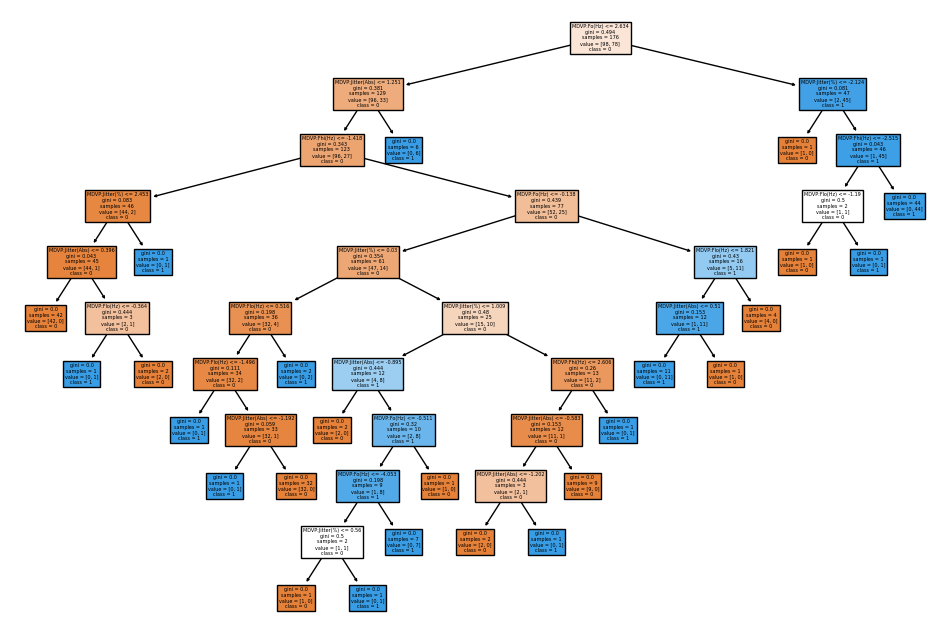

In [8]:
# Extract the trained DecisionTreeClassifier
dt_classifier = best_pipeline_pow.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=list(train_X.columns), class_names=[str(class_label) for class_label in dt_classifier.classes_])
plt.show()

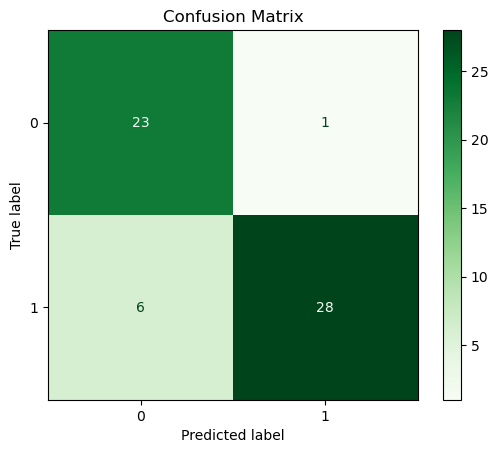

In [9]:
# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline_pow.classes_)
disp.plot(cmap='Greens') 
plt.title('Confusion Matrix')
plt.show()

In [22]:
best_tree = best_pipeline_pow.named_steps['classifier']

# Access the tree structure
tree_structure = best_tree.tree_

def calculate_entropy_and_gini(tree, node):
    # Get the class distribution at the current node
    class_distribution = tree.value[node][0]

    # Calculate entropy
    entropy = -np.sum(np.nan_to_num(class_distribution / np.sum(class_distribution)) * np.log2(np.nan_to_num(class_distribution / np.sum(class_distribution))))

    # Calculate Gini index
    gini_index = 1 - np.sum((class_distribution / np.sum(class_distribution))**2)

    return entropy, gini_index

# Calculate entropy and Gini index for the root node
root_entropy, root_gini = calculate_entropy_and_gini(tree_structure, 0)

print(f"Entropy at root node: {root_entropy}")
print(f"Gini Index at root node: {root_gini}")

# Calculate entropy and Gini index for the final node, the final node needs to be changed with each decision tree run.
max_entropy, max_gini = calculate_entropy_and_gini(tree_structure,  6) 

print(f"Entropy at final node: {max_entropy}")
print(f"Gini Index at final node: {max_gini}")

Entropy at root node: 0.9906649266228326
Gini Index at root node: 0.4935433884297521
Entropy at final node: 0.9182958340544896
Gini Index at final node: 0.4444444444444444


Although the test accuracy is fairly high at around 90%, the entropy and gini index from the root node to the final node does not show a significant decrease in disorder or impurity with each node split.

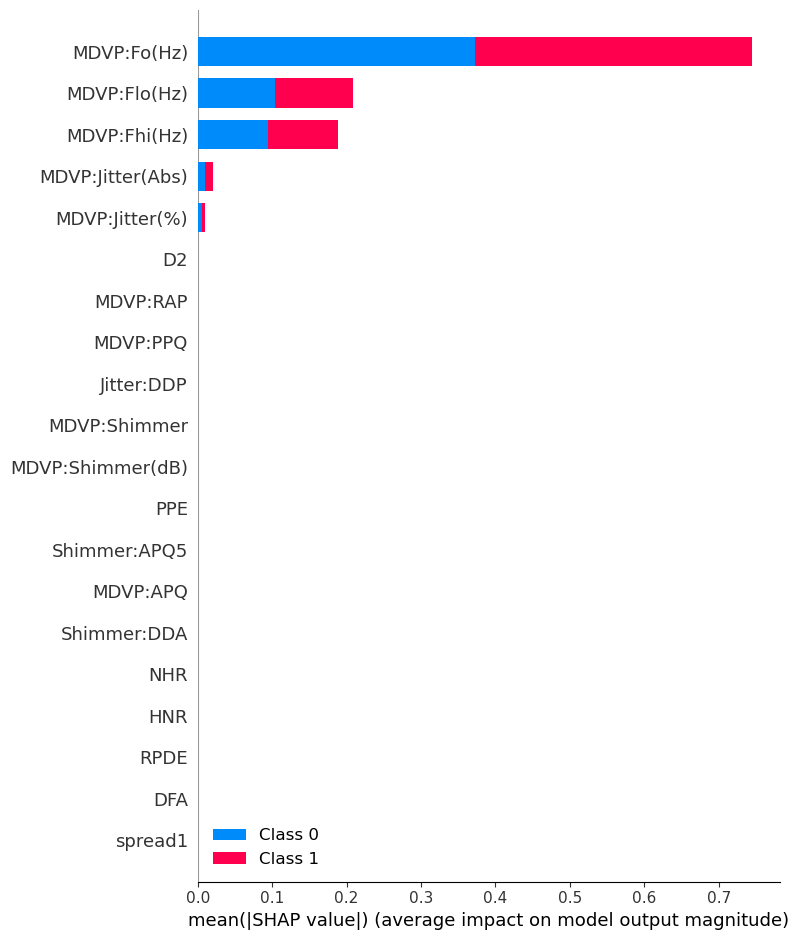

In [11]:
# Using the tree based explainer
explainer = shap.TreeExplainer(best_pipeline_pow.named_steps['classifier'])

# Generate SHAP values for a set of samples 
shap_values = explainer.shap_values(val_X)

# Summary plot
shap.summary_plot(shap_values, val_X)

The summary plot shows that MDVP:Fo(Hz) has the largest contribution to determining the classification.

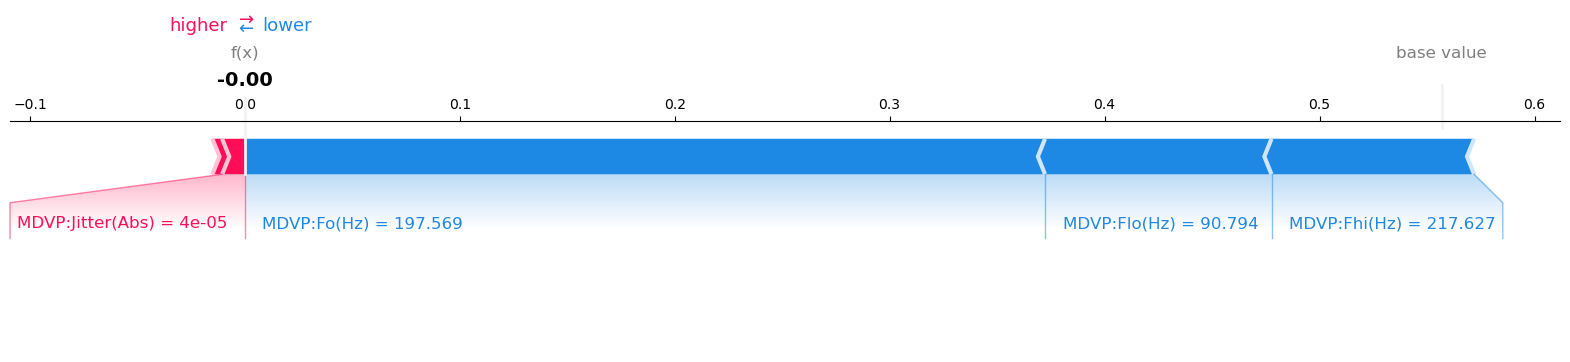

In [12]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], test_X.iloc[0, :], matplotlib = True)

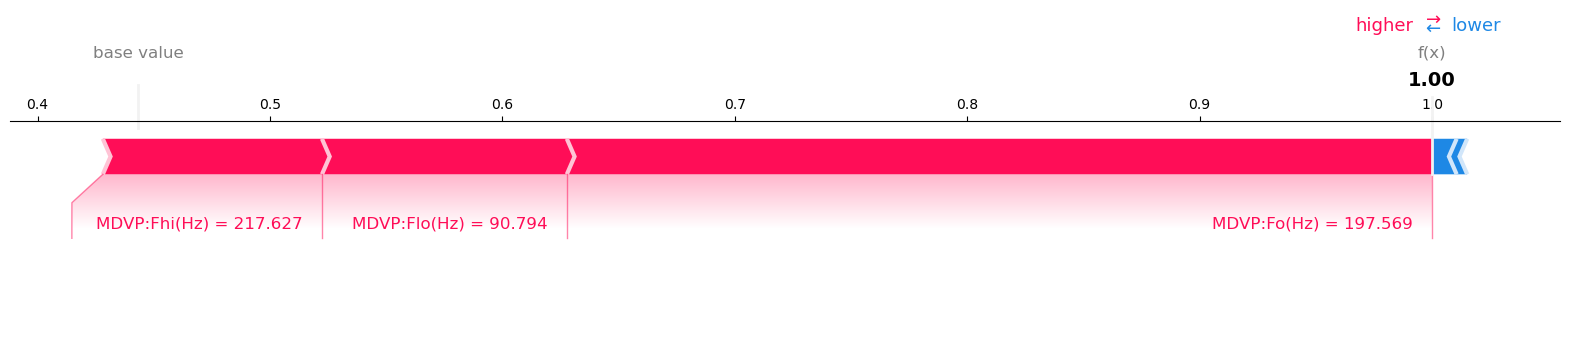

In [13]:
shap.plots.force(explainer.expected_value[1], shap_values[1][0,:], test_X.iloc[0, :], matplotlib = True)

## RobustScaler - PCA - Decision Tree

In [14]:
def objective(trial):
    # PCA
    pca_n_components = trial.suggest_int('pca_n_components', 1, train_X.shape[1], log=False)
    pca = PCA(n_components=pca_n_components)

    # Decision Tree
    dt_max_depth = trial.suggest_int('dt_max_depth', 1, 23, log=False)
    dt_max_feats = trial.suggest_int('dt_max_feats', 1, 23, log=False)
    dt = DecisionTreeClassifier(max_depth=dt_max_depth)
#    params = {
#        'max_depth': trial.suggest_int('max_depth', 1, 32),
#        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
#        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
#        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
#        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 32),
#        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
#    }
#    dt = DecisionTreeClassifier(**params)

    # Create the pipeline
    pipeline = Pipeline([
        ('robust_scaler', RobustScaler()),
        ('pca', pca),
        ('classifier', dt)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(train_X, train_y)

    # Evaluate the pipeline on the validation set
    y_pred_val = pipeline.predict(val_X)
    accuracy_val = accuracy_score(val_y, y_pred_val)

    return 1.0 - accuracy_val

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
# Extract hyperparameters for DecisionTreeClassifier

#dt_params = {
#    'max_depth': best_params['max_depth'],
#    'min_samples_split': best_params['min_samples_split'],
#    'min_samples_leaf': best_params['min_samples_leaf'],
#    'max_features': best_params['max_features'],
#    'max_leaf_nodes': best_params['max_leaf_nodes'],
#    'criterion': best_params['criterion']
#}

# Train the best pipeline on the entire training set
best_pipeline_rob = Pipeline([
    ('robust_scaler', RobustScaler()),
    ('pca', PCA(random_state=42,  n_components=best_params['pca_n_components'])),
    ('classifier', DecisionTreeClassifier(random_state=42,  max_depth=best_params['dt_max_depth'],max_features=best_params['dt_max_feats']))
#    ('classifier', DecisionTreeClassifier(**dt_params))
])
best_pipeline_rob.fit(train_X, train_y)

# Evaluate the best pipeline on the test set
y_pred_test = best_pipeline_rob.predict(test_X)
accuracy_test = accuracy_score(test_y, y_pred_test)
print(f"Pipeline Accuracy on Test Set: {accuracy_test}")

[I 2023-12-06 19:27:27,343] A new study created in memory with name: no-name-d1667133-aad3-42ea-b03f-0001b81f294c
[I 2023-12-06 19:27:27,361] Trial 0 finished with value: 0.12068965517241381 and parameters: {'pca_n_components': 15, 'dt_max_depth': 11, 'dt_max_feats': 10}. Best is trial 0 with value: 0.12068965517241381.
[I 2023-12-06 19:27:27,379] Trial 1 finished with value: 0.18965517241379315 and parameters: {'pca_n_components': 3, 'dt_max_depth': 20, 'dt_max_feats': 13}. Best is trial 0 with value: 0.12068965517241381.
[I 2023-12-06 19:27:27,397] Trial 2 finished with value: 0.10344827586206895 and parameters: {'pca_n_components': 20, 'dt_max_depth': 13, 'dt_max_feats': 2}. Best is trial 2 with value: 0.10344827586206895.
[I 2023-12-06 19:27:27,413] Trial 3 finished with value: 0.12068965517241381 and parameters: {'pca_n_components': 17, 'dt_max_depth': 23, 'dt_max_feats': 16}. Best is trial 2 with value: 0.10344827586206895.
[I 2023-12-06 19:27:27,433] Trial 4 finished with value:

[I 2023-12-06 19:27:28,829] Trial 39 finished with value: 0.15517241379310343 and parameters: {'pca_n_components': 13, 'dt_max_depth': 10, 'dt_max_feats': 11}. Best is trial 20 with value: 0.08620689655172409.
[I 2023-12-06 19:27:28,873] Trial 40 finished with value: 0.08620689655172409 and parameters: {'pca_n_components': 17, 'dt_max_depth': 18, 'dt_max_feats': 7}. Best is trial 20 with value: 0.08620689655172409.
[I 2023-12-06 19:27:28,909] Trial 41 finished with value: 0.15517241379310343 and parameters: {'pca_n_components': 2, 'dt_max_depth': 22, 'dt_max_feats': 8}. Best is trial 20 with value: 0.08620689655172409.
[I 2023-12-06 19:27:28,945] Trial 42 finished with value: 0.10344827586206895 and parameters: {'pca_n_components': 17, 'dt_max_depth': 18, 'dt_max_feats': 7}. Best is trial 20 with value: 0.08620689655172409.
[I 2023-12-06 19:27:28,986] Trial 43 finished with value: 0.10344827586206895 and parameters: {'pca_n_components': 16, 'dt_max_depth': 14, 'dt_max_feats': 10}. Best

Pipeline Accuracy on Test Set: 0.9310344827586207


In [15]:
# Get the most important features from PCA
most_important_features = get_most_important_features(best_pipeline_rob.named_steps['pca'], train_X)

# Display the most important features
display(most_important_features)

,0,1
0,PC0,NHR
1,PC1,NHR
2,PC2,spread2
3,PC3,spread2
4,PC4,spread2
5,PC5,D2
6,PC6,D2
7,PC7,MDVP:Fhi(Hz)
8,PC8,MDVP:APQ
9,PC9,RPDE


The above figure shows the features with the most expained variance on the PCA components. 

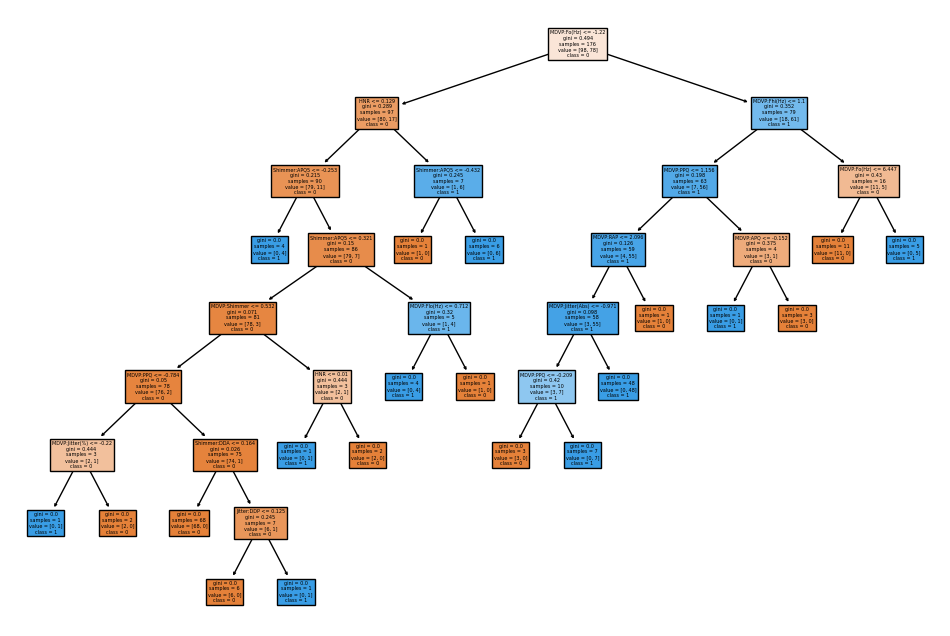

In [16]:
# Extract the trained DecisionTreeClassifier
dt_classifier = best_pipeline_rob.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=list(train_X.columns), class_names=[str(class_label) for class_label in dt_classifier.classes_])
plt.show()

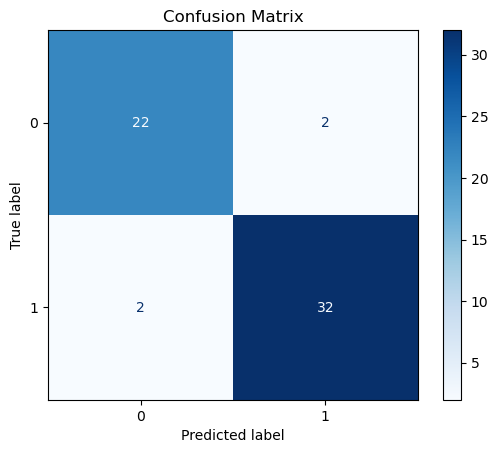

In [17]:
# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline_rob.classes_)
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

In [18]:
best_tree = best_pipeline_rob.named_steps['classifier']

# Access the tree structure
tree_structure = best_tree.tree_

# Calculate entropy and Gini index for the root node
root_entropy, root_gini = calculate_entropy_and_gini(tree_structure, 0)

print(f"Entropy at root node: {root_entropy}")
print(f"Gini Index at root node: {root_gini}")

# Calculate entropy and Gini index for the final node, the final node needs to be changed with each decision tree run.
max_entropy, max_gini = calculate_entropy_and_gini(tree_structure,  6)

print(f"Entropy at final node: {max_entropy}")
print(f"Gini Index at final node: {max_gini}")

Entropy at root node: 0.9906649266228326
Gini Index at root node: 0.4935433884297521
Entropy at final node: 0.17203694935311378
Gini Index at final node: 0.04996712689020377


This model performed much better than the PowerTransformer model. The entropy and gini index were reduced as the nodes split and the test accuracy is high. 

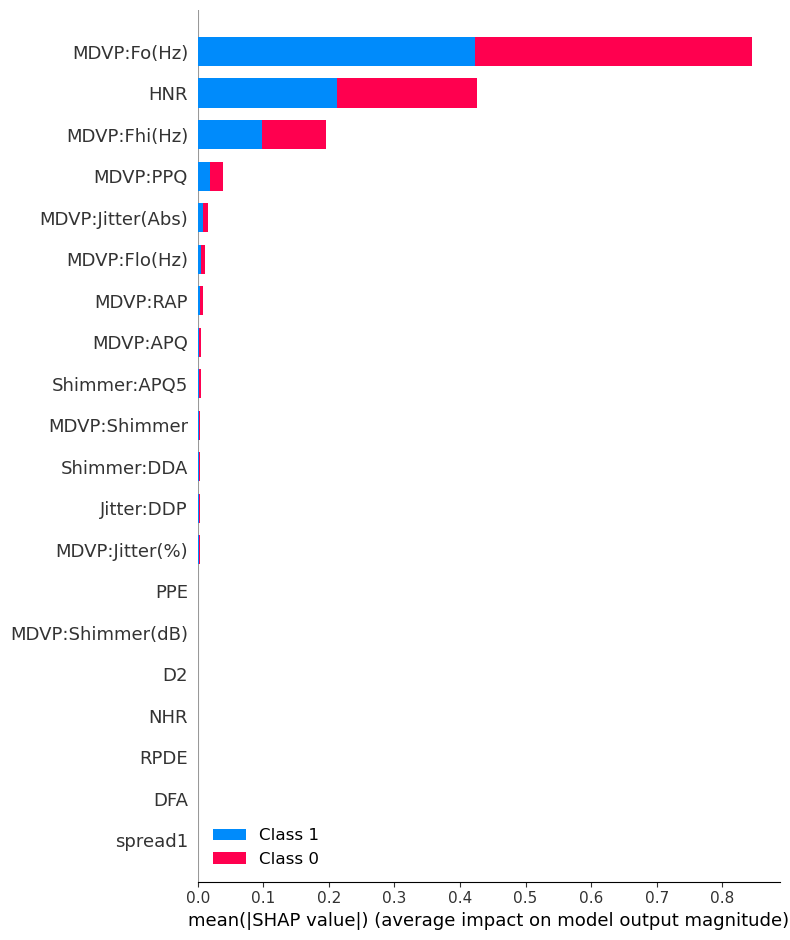

In [19]:
# Using the tree based explainer
explainer = shap.TreeExplainer(best_pipeline_rob.named_steps['classifier'])

# Generate SHAP values for a set of samples 
shap_values = explainer.shap_values(test_X)

# Summary plot
shap.summary_plot(shap_values, test_X)

In this summary plot for the use of RobustScaler shows that MDVP:fo(Hz), MDVP:flo(Hz), and MDVP:Fhi(Hz) play the most important role in determining the classification. 

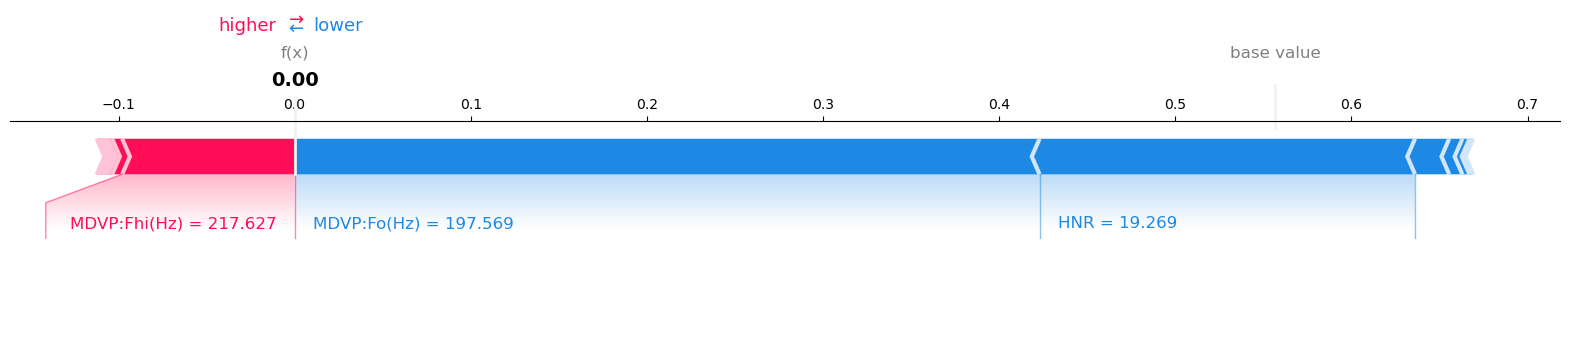

In [20]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], test_X.iloc[0, :], matplotlib = True)

In this plot we can see MDVP:flo(Hz) has contributed to pushing the classification to a 1 and that MDVP:Fo(Hz) is the feature that is pushing the value lower to be 0.

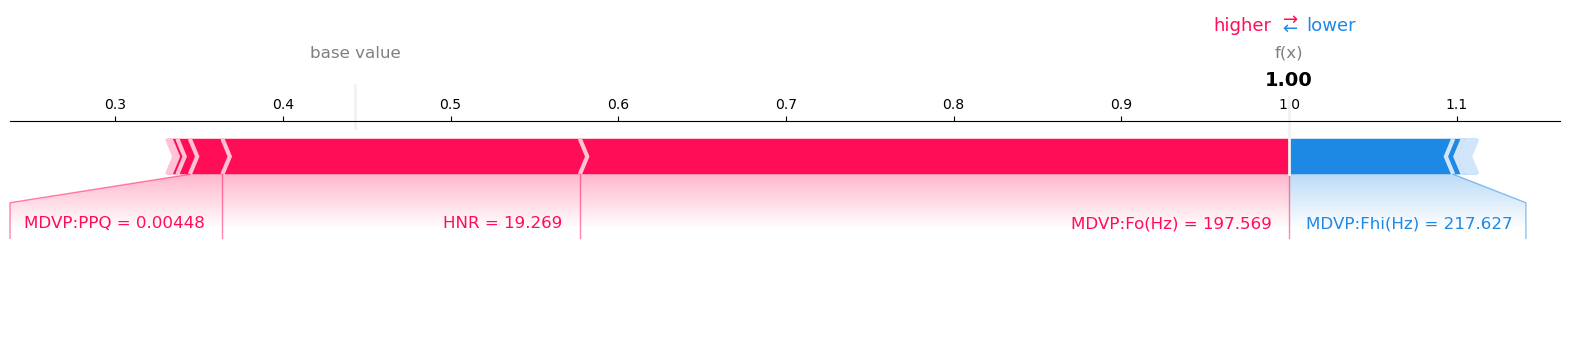

In [21]:
shap.plots.force(explainer.expected_value[1], shap_values[1][0,:], test_X.iloc[0, :], matplotlib = True)

This plot shows that the feature Jitter:DDP is the driving force in increasing the classification to a 1|. The features MDVP:flo(Hz), MDVP:Fhi(Hz), and MDVP:RAP can change the classification if decreased.. 